In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from itertools import chain
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.animation as animation
from IPython.display import HTML
import copy

## 6.3 ヒューリスティック探索
### 6.3.1 最良優先探索

#### 一般化

In [2]:
# connect[i]はノード(i)と連結してるノード
connect = [[1, 5], [0, 2, 6], [1, 3, 7], [2, 4, 8], [3, 9],
        [6, 0, 10], [5, 7, 1, 11], [6, 8, 2, 12], [7, 9, 3, 13], [8, 4, 14],
        [11, 5, 15], [10, 12, 6, 16], [11, 13, 7, 17], [12, 14, 8, 18], [13, 9, 19],
        [16, 10, 20], [15, 17, 11, 21], [16, 18, 12, 22], [17, 19, 13, 23], [18, 14, 24],
        [21, 15], [20, 22, 16], [21, 23, 17], [22, 24, 18], [23, 19]]

width = 5
height = 5
goal = 23
hn = []

def manhattan_distance(i, height, width, goal):
    return np.abs(i//height - goal//height) + np.abs(i%width - goal%width)

# max(chain(*connect))はconnectの中の最大値を抜き出してるだけ.
for i in range(max(chain(*connect)) + 1):
    hn.append(manhattan_distance(i, height, width, goal))

In [3]:
H, W = 5, 5
grid = []
for i in range(5):
    grid.append(hn[i*5:i*5+5])
print(*['-']*W, sep='+')
for row in grid:
    print(*row, sep='|')
    print(*['-']*W, sep='+')

-+-+-+-+-
7|6|5|4|5
-+-+-+-+-
6|5|4|3|4
-+-+-+-+-
5|4|3|2|3
-+-+-+-+-
4|3|2|1|2
-+-+-+-+-
3|2|1|0|1
-+-+-+-+-


In [4]:
# prevは一個前にいた場所の値が格納される
# サンプルコードでは使ってるけどここではいらないので使いません
prev = [-1]*(max(chain(*connect)) + 1)
open_list = [0]
close_list = []

# 貪欲につながっているnodeの中で一番近いnodeへ移動するだけ
while open_list:
    now = open_list.pop(0)
    close_list.append(now)
    distance = [hn[i] for i in connect[now]]
    min_dis_idx = np.argsort(distance)[0]
    next_idx = connect[now][min_dis_idx]
    print(f'now: {now}, connect[now]: {connect[now]}\n \
distance: {distance}, min_distance_index: {min_dis_idx}, next_idx: {next_idx}\n')
    prev[next_idx] = now
    open_list.append(next_idx)
    if next_idx==goal:
        break


print(f'close_list:\n {close_list}')

now: 0, connect[now]: [1, 5]
 distance: [6, 6], min_distance_index: 0, next_idx: 1

now: 1, connect[now]: [0, 2, 6]
 distance: [7, 5, 5], min_distance_index: 1, next_idx: 2

now: 2, connect[now]: [1, 3, 7]
 distance: [6, 4, 4], min_distance_index: 1, next_idx: 3

now: 3, connect[now]: [2, 4, 8]
 distance: [5, 5, 3], min_distance_index: 2, next_idx: 8

now: 8, connect[now]: [7, 9, 3, 13]
 distance: [4, 4, 4, 2], min_distance_index: 3, next_idx: 13

now: 13, connect[now]: [12, 14, 8, 18]
 distance: [3, 3, 3, 1], min_distance_index: 3, next_idx: 18

now: 18, connect[now]: [17, 19, 13, 23]
 distance: [2, 2, 2, 0], min_distance_index: 3, next_idx: 23

close_list:
 [0, 1, 2, 3, 8, 13, 18]


In [5]:
# 本来はprevを使うのですが、今回はclose_listで十分なので要りません
close_list.append(23)
route = close_list[::-1]
route

[23, 18, 13, 8, 3, 2, 1, 0]

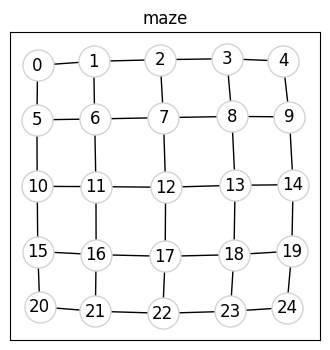

In [6]:
tree_graph = []
for i, tr in enumerate(connect):
    for j in tr:
        tree_graph.append((i, j))

G = nx.Graph()
G.add_nodes_from(range(max(chain(*connect))+1))
G.add_edges_from(tree_graph)
pos = nx.spring_layout(G, seed=22)
plt.figure(figsize=(4, 4))
plt.title('maze')
nx.draw_networkx(G, pos, node_color='w', edgecolors='lightgrey',
        node_size=500, with_labels=True)


In [7]:
def MakeField(maxnode, close_list, route):
    pc = ['w']*maxnode

    for i in close_list:
        pc[i]='lightgreen'
    if len(close_list)>0:
        pc[close_list[-1]]='lightblue'
    for i in route:
        pc[i]='lightblue'
    return pc

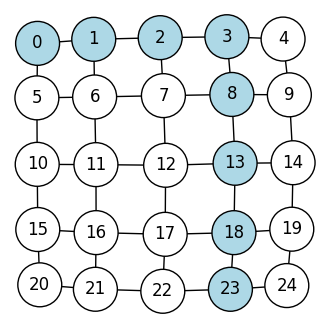

In [8]:
n = 0

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
def update(k):
    global n
    plt.cla()
    plt.axis('off')
    if n<len(close_list):
        pc = MakeField(len(list(G)), close_list[:n], [])
    else:
        pc = MakeField(len(list(G)), close_list, route[:n-len(close_list)])

    nx.draw_networkx(G, pos, node_color=pc, edgecolors='k', edge_color='k', node_size=1000, with_labels=True)
    n = n + 1

ani = animation.FuncAnimation(fig, update, interval = 100, frames = len(close_list)+len(route), repeat=False)
HTML(ani.to_jshtml())

### 6.3.2 A*(Aスター)アルゴリズム

In [9]:
connect = [[1, 5], [0, 2, 6], [1, 3, 7], [2, 4, 8], [3, 9],
        [6, 0, 10], [5, 7, 1, 11], [6, 8, 2, 12], [7, 9, 3, 13], [8, 4, 14],
        [11, 5, 15], [10, 12, 6, 16], [11, 13, 7, 17], [12, 14, 8, 18], [13, 9, 19],
        [16, 10, 20], [15, 17, 11, 21], [16, 18, 12, 22], [17, 19, 13, 23], [18, 14, 24],
        [21, 15], [20, 22, 16], [21, 23, 17], [22, 24, 18], [23, 19]]

width = 5
height = 5
goal = 23
hn = []
max_distance = max(chain(*connect))+1
for i in range(max_distance):
    hn.append(manhattan_distance(i, height, width, goal))

gn = [100]*max_distance
gn[0] = 0
fn = [100]*max_distance
fn[0] = hn[0]

cost = copy.deepcopy(connect)
for i in range(len(connect)):
    for j in range(len(connect[i])):
        cost[i][j] = 1

prev = [-1]*max_distance
open_list = [0]
close_list = []

while open_list:
    a = [fn[i] for i in open_list]
    b = np.argsort(a)[0]
    now = open_list.pop(b)
    close_list.append(now)            
    for j, i in enumerate(connect[now]):
        if gn[i] > gn[now] + cost[now][j]:
            gn[i] = gn[now] + cost[now][j]
        if not(i in close_list):
            if fn[i] > gn[i] + hn[i]:
                fn[i] = gn[i] + hn[i]
                prev[i] = now
                if not(i in open_list):
                    open_list.append(i)
    if goal in open_list:
        break

print(close_list)

[0, 1, 5, 2, 6, 10, 3, 7, 11, 15, 8, 12, 16, 20, 13, 17, 21, 18]


In [10]:
p = goal
route = []
route.append(p)

while p:
    p = prev[p]
    route.append(p)
print(route)

[23, 18, 13, 8, 3, 2, 1, 0]


In [11]:
tree_graph = []
for i, tr in enumerate(connect):
    for j in tr:
        tree_graph.append((i,j))
G = nx.Graph()  # 無向グラフ
G.add_nodes_from(range(max(chain(*connect))+1))
G.add_edges_from(tree_graph)
pos = nx.spring_layout(G, seed=22)#7,14


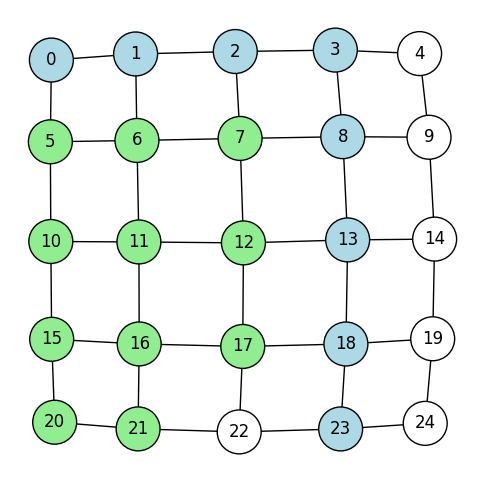

In [12]:
n = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
def update(k):
    global n
    plt.cla()
    plt.axis('off')
    if n<len(close_list):
        pc = MakeField(len(list(G)), close_list[:n], [])
    else:
        pc = MakeField(len(list(G)), close_list, route[:n-len(close_list)])

    nx.draw_networkx(G, pos, node_color=pc, edgecolors='k', edge_color='k', node_size=1000, with_labels=True)
    n = n + 1
    
ani = animation.FuncAnimation(fig, update, interval = 100, frames = len(close_list)+len(route), repeat=False)
HTML(ani.to_jshtml())